In [23]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score

In [24]:
df = pd.read_csv('../data/train.csv')
df_val = pd.read_csv('../data/val.csv')

In [25]:
features = list(df.columns.array)
features.reverse()
label = features.pop(0)
features.reverse()
x_train = df[features]
y_train = df['Body_Level']
x_val = df_val[features]
y_val = df_val['Body_Level']

In [26]:
# First, let's transform numerical data to categorical data. This can be done by dividing them into ranges.
def convert_to_categorical(feature, percentiles_given=None, num_of_categs=5):
    cat_feature = feature.copy()
    percentiles = None
    if percentiles_given is None:
        percents = []
        for i in range(num_of_categs-1):
            percents.append((i+1.0)/num_of_categs)
        percentiles = np.quantile(list(feature),percents)
    else:
        percentiles = percentiles_given
    for i in range(len(feature)):
        for j in range(len(percentiles)+1):
            if j == (len(percentiles)):
                cat_feature[i] = j
                break
            if j == 0 and feature[i] < percentiles[j]:
                cat_feature[i] = j
                break
            elif feature[i] >= percentiles[j-1] and feature[i] < percentiles[j]:
                cat_feature[i] = j
                break
    return cat_feature, percentiles

In [27]:
# Second, let's transform map the categorical data to values.
def map_categorical(feature, categs_given=None):
    cat_feature = feature.copy()
    categs = None
    if categs_given is None:
        categs = list(feature.unique())
    else:
        categs = categs_given
    for i in range(len(feature)):
        for j in range(len(categs)):
            if feature[i] == categs[j]:
                cat_feature[i] = j
                break
    return cat_feature, categs

In [28]:
df.drop('Body_Level', inplace=True, axis=1)
df_val.drop('Body_Level', inplace=True, axis=1)
x_train_10_bins = df.copy(deep=True)
x_val_10_bins = df_val.copy(deep=True)
x_train_16_bins = df.copy(deep=True)
x_val_16_bins = df_val.copy(deep=True)
x_train_30_bins = df.copy(deep=True)
x_val_30_bins = df_val.copy(deep=True)
percentiles_10 = dict()
percentiles_16 = dict()
percentiles_30 = dict()
numerical_features = ['Age', 'Height', 'Weight', 'Veg_Consump', 'Water_Consump', 'Meal_Count', 'Phys_Act', 'Time_E_Dev']
for feature in numerical_features:
    x_train_10_bins[feature], percentiles_10_ = convert_to_categorical(x_train[feature], num_of_categs=10)
    x_train_16_bins[feature], percentiles_16_ = convert_to_categorical(x_train[feature], num_of_categs=16)
    x_train_30_bins[feature], percentiles_30_ = convert_to_categorical(x_train[feature], num_of_categs=30)
    percentiles_10[feature] = percentiles_10_
    percentiles_16[feature] = percentiles_16_
    percentiles_30[feature] = percentiles_30_
for feature in numerical_features:
    x_val_10_bins[feature], _ = convert_to_categorical(x_val[feature], percentiles_given=percentiles_10[feature], num_of_categs=10)
    x_val_16_bins[feature], _ = convert_to_categorical(x_val[feature], percentiles_given=percentiles_16[feature], num_of_categs=16)
    x_val_30_bins[feature], _ = convert_to_categorical(x_val[feature], percentiles_given=percentiles_30[feature], num_of_categs=30)

In [29]:
categorical_features = ['Gender','H_Cal_Consump', 'Smoking', 'Fam_Hist', 'H_Cal_Burn', 'Alcohol_Consump', 'Food_Between_Meals', 'Transport']
categs = dict()
for feature in categorical_features:
    temp, categs_ = map_categorical(x_train[feature])
    x_train_10_bins[feature] = temp
    x_train_16_bins[feature] = temp
    x_train_30_bins[feature] = temp
    categs[feature] = categs_
for feature in categorical_features:
    temp, _ = map_categorical(x_val[feature], categs_given=categs[feature])
    x_val_10_bins[feature] = temp
    x_val_16_bins[feature] = temp
    x_val_30_bins[feature] = temp

### 10 bins for numerical data + Default Parameters: alpha=1.0, force_alpha=False, fit_prior=True, class_prior=None

In [30]:
# Training
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train_10_bins, y_train)

# Prediction
naive_bayes_predictions = naive_bayes_model.predict(x_val_10_bins)

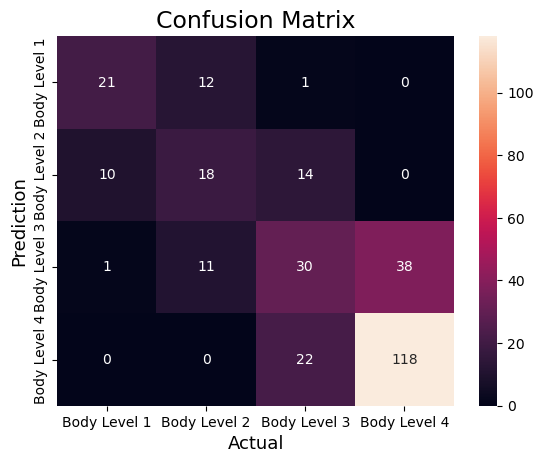

In [31]:
# Compute the confusion matrix.
cm = confusion_matrix(y_val,naive_bayes_predictions)
# Plot the confusion matrix.
labels = list(set(y_train))
labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [32]:
# Finding the accuracy.
accuracy = accuracy_score(y_val,naive_bayes_predictions)
print("Accuracy   :", accuracy)

# Finding precision and recall
precision, recall, F1_score, support = score(y_val,naive_bayes_predictions)
print("Precision :", precision, "Macro Precision :", sum(precision)/len(precision))
print("Recall    :", recall, "Macro Recall    :", sum(recall)/len(recall))
print("F1-score  :", F1_score, "Macro F1-score  :", sum(F1_score)/len(F1_score))
print(classification_report(y_val,naive_bayes_predictions))

Accuracy   : 0.6317567567567568
Precision : [0.65625    0.43902439 0.44776119 0.75641026] Macro Precision : 0.5748614601710024
Recall    : [0.61764706 0.42857143 0.375      0.84285714] Macro Recall    : 0.5660189075630252
F1-score  : [0.63636364 0.43373494 0.40816327 0.7972973 ] Macro F1-score  : 0.5688897846815231
              precision    recall  f1-score   support

Body Level 1       0.66      0.62      0.64        34
Body Level 2       0.44      0.43      0.43        42
Body Level 3       0.45      0.38      0.41        80
Body Level 4       0.76      0.84      0.80       140

    accuracy                           0.63       296
   macro avg       0.57      0.57      0.57       296
weighted avg       0.62      0.63      0.62       296



### 16 bins for numerical data + Default Parameters: alpha=1.0, force_alpha=False, fit_prior=True, class_prior=None

In [34]:
# Training
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train_16_bins, y_train)

# Prediction
naive_bayes_predictions = naive_bayes_model.predict(x_val_16_bins)

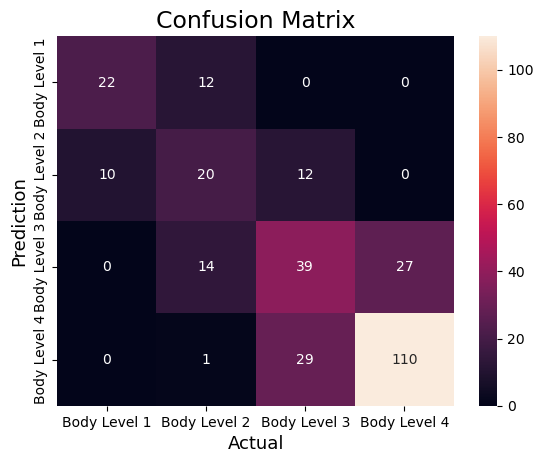

In [35]:
# Compute the confusion matrix.
cm = confusion_matrix(y_val,naive_bayes_predictions)
# Plot the confusion matrix.
labels = list(set(y_train))
labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [36]:
# Finding the accuracy.
accuracy = accuracy_score(y_val,naive_bayes_predictions)
print("Accuracy   :", accuracy)

# Finding precision and recall
precision, recall, F1_score, support = score(y_val,naive_bayes_predictions)
print("Precision :", precision, "Macro Precision :", sum(precision)/len(precision))
print("Recall    :", recall, "Macro Recall    :", sum(recall)/len(recall))
print("F1-score  :", F1_score, "Macro F1-score  :", sum(F1_score)/len(F1_score))
print(classification_report(y_val,naive_bayes_predictions))

Accuracy   : 0.6452702702702703
Precision : [0.6875     0.42553191 0.4875     0.80291971] Macro Precision : 0.6008629057307036
Recall    : [0.64705882 0.47619048 0.4875     0.78571429] Macro Recall    : 0.5991158963585435
F1-score  : [0.66666667 0.4494382  0.4875     0.79422383] Macro F1-score  : 0.5994571739071648
              precision    recall  f1-score   support

Body Level 1       0.69      0.65      0.67        34
Body Level 2       0.43      0.48      0.45        42
Body Level 3       0.49      0.49      0.49        80
Body Level 4       0.80      0.79      0.79       140

    accuracy                           0.65       296
   macro avg       0.60      0.60      0.60       296
weighted avg       0.65      0.65      0.65       296



### 30 bins for numerical data + Default Parameters: alpha=1.0, force_alpha=False, fit_prior=True, class_prior=None

In [37]:
# Training
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train_30_bins, y_train)

# Prediction
naive_bayes_predictions = naive_bayes_model.predict(x_val_30_bins)

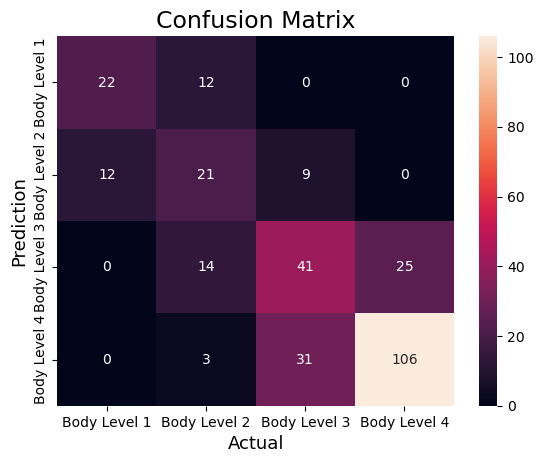

In [38]:
# Compute the confusion matrix.
cm = confusion_matrix(y_val,naive_bayes_predictions)
# Plot the confusion matrix.
labels = list(set(y_train))
labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [40]:
# Finding the accuracy.
accuracy = accuracy_score(y_val,naive_bayes_predictions)
print("Accuracy   :", accuracy)

# Finding precision and recall
precision, recall, F1_score, support = score(y_val,naive_bayes_predictions)
print("Precision :", precision, "Macro Precision :", sum(precision)/len(precision))
print("Recall    :", recall, "Macro Recall    :", sum(recall)/len(recall))
print("F1-score  :", F1_score, "Macro F1-score  :", sum(F1_score)/len(F1_score))
print(classification_report(y_val,naive_bayes_predictions))

Accuracy   : 0.6418918918918919
Precision : [0.64705882 0.42       0.50617284 0.80916031] Macro Precision : 0.595597992094774
Recall    : [0.64705882 0.5        0.5125     0.75714286] Macro Recall    : 0.6041754201680671
F1-score  : [0.64705882 0.45652174 0.50931677 0.78228782] Macro F1-score  : 0.5987962889311027
              precision    recall  f1-score   support

Body Level 1       0.65      0.65      0.65        34
Body Level 2       0.42      0.50      0.46        42
Body Level 3       0.51      0.51      0.51        80
Body Level 4       0.81      0.76      0.78       140

    accuracy                           0.64       296
   macro avg       0.60      0.60      0.60       296
weighted avg       0.65      0.64      0.65       296



### Data without using bins and using one hot vectors

In [41]:
%run "../all_numerical_data.ipynb"

In [42]:
# Training
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train, y_train)

# Prediction
naive_bayes_predictions = naive_bayes_model.predict(x_val)

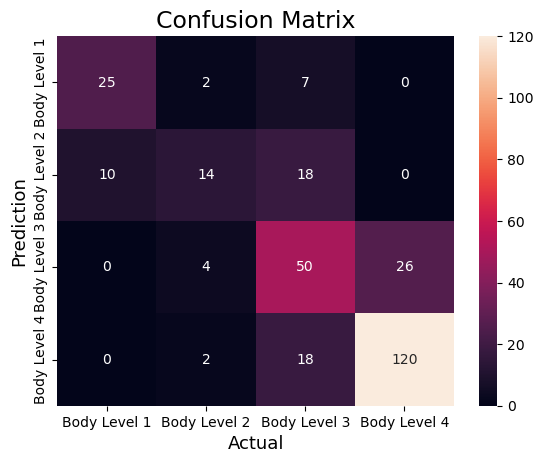

In [43]:
# Compute the confusion matrix.
cm = confusion_matrix(y_val,naive_bayes_predictions)
# Plot the confusion matrix.
labels = list(set(y_train))
labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [44]:
# Finding the accuracy.
accuracy = accuracy_score(y_val,naive_bayes_predictions)
print("Accuracy   :", accuracy)

# Finding precision and recall
precision, recall, F1_score, support = score(y_val,naive_bayes_predictions)
print("Precision :", precision, "Macro Precision :", sum(precision)/len(precision))
print("Recall    :", recall, "Macro Recall    :", sum(recall)/len(recall))
print("F1-score  :", F1_score, "Macro F1-score  :", sum(F1_score)/len(F1_score))
print(classification_report(y_val,naive_bayes_predictions))

Accuracy   : 0.706081081081081
Precision : [0.71428571 0.63636364 0.53763441 0.82191781] Macro Precision : 0.6775503918676697
Recall    : [0.73529412 0.33333333 0.625      0.85714286] Macro Recall    : 0.6376925770308123
F1-score  : [0.72463768 0.4375     0.57803468 0.83916084] Macro F1-score  : 0.644833300600296
              precision    recall  f1-score   support

Body Level 1       0.71      0.74      0.72        34
Body Level 2       0.64      0.33      0.44        42
Body Level 3       0.54      0.62      0.58        80
Body Level 4       0.82      0.86      0.84       140

    accuracy                           0.71       296
   macro avg       0.68      0.64      0.64       296
weighted avg       0.71      0.71      0.70       296



### Data without using bins and mapping categories to numbers

In [45]:
df = pd.read_csv('../data/train.csv')
df_val = pd.read_csv('../data/val.csv')

In [46]:
features = list(df.columns.array)
features.reverse()
label = features.pop(0)
features.reverse()
x_train = df[features]
y_train = df['Body_Level']
x_val = df_val[features]
y_val = df_val['Body_Level']

In [47]:
categorical_features = ['Gender','H_Cal_Consump', 'Smoking', 'Fam_Hist', 'H_Cal_Burn', 'Alcohol_Consump', 'Food_Between_Meals', 'Transport']
categs = dict()
for feature in categorical_features:
    temp, categs_ = map_categorical(x_train[feature])
    x_train[feature] = temp
    categs[feature] = categs_
for feature in categorical_features:
    temp, _ = map_categorical(x_val[feature], categs_given=categs[feature])
    x_val[feature] = temp

/home/iten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/iten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [48]:
# Training
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(x_train, y_train)

# Prediction
naive_bayes_predictions = naive_bayes_model.predict(x_val)

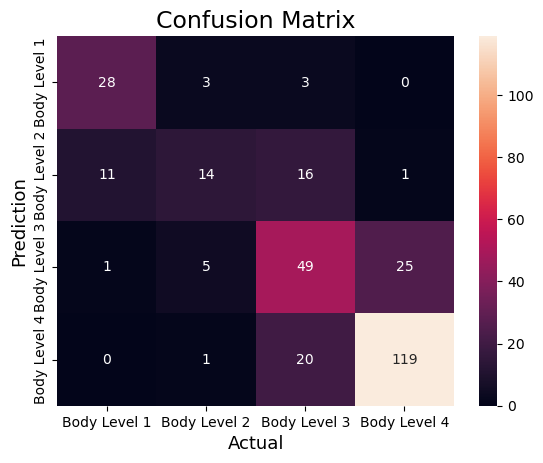

In [49]:
# Compute the confusion matrix.
cm = confusion_matrix(y_val,naive_bayes_predictions)
# Plot the confusion matrix.
labels = list(set(y_train))
labels.sort()
sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [50]:
# Finding the accuracy.
accuracy = accuracy_score(y_val,naive_bayes_predictions)
print("Accuracy   :", accuracy)

# Finding precision and recall
precision, recall, F1_score, support = score(y_val,naive_bayes_predictions)
print("Precision :", precision, "Macro Precision :", sum(precision)/len(precision))
print("Recall    :", recall, "Macro Recall    :", sum(recall)/len(recall))
print("F1-score  :", F1_score, "Macro F1-score  :", sum(F1_score)/len(F1_score))
print(classification_report(y_val,naive_bayes_predictions))

Accuracy   : 0.7094594594594594
Precision : [0.7        0.60869565 0.55681818 0.82068966] Macro Precision : 0.6715508722911272
Recall    : [0.82352941 0.33333333 0.6125     0.85      ] Macro Recall    : 0.6548406862745098
F1-score  : [0.75675676 0.43076923 0.58333333 0.83508772] Macro F1-score  : 0.6514867600393917
              precision    recall  f1-score   support

Body Level 1       0.70      0.82      0.76        34
Body Level 2       0.61      0.33      0.43        42
Body Level 3       0.56      0.61      0.58        80
Body Level 4       0.82      0.85      0.84       140

    accuracy                           0.71       296
   macro avg       0.67      0.65      0.65       296
weighted avg       0.71      0.71      0.70       296

